In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano
import numpy as np
from keras.layers import Input, Dense, convolutional,Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Model
from keras.optimizers import *

%matplotlib inline


from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense

from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.regularizers import *
from keras.layers.normalization import *


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
Using Theano backend.


In [2]:
x_train = np.genfromtxt('x_train.out')
y_train = np.genfromtxt('y_train.out')
vx_train = np.genfromtxt('vx_train.out')
vy_train = np.genfromtxt('vy_train.out')
x_test = np.genfromtxt('x_test.out')
y_test = np.genfromtxt('y_test.out')

In [3]:
print (x_train.shape)
print (y_train.shape)
print (vx_train.shape)
print (vy_train.shape)
print (x_test.shape)
print (y_test.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)
(10000, 784)
(10000,)


In [4]:
train_x_temp = x_train.reshape(-1,1, 28, 28)
val_x_temp = vx_train.reshape(-1,1, 28, 28)
test_x_temp=x_test.reshape(-1,1, 28, 28)
print(train_x_temp.shape)
print((train_x_temp.dtype))

print(val_x_temp.shape)
print(val_x_temp.dtype)

print(test_x_temp.shape)
print(test_x_temp.dtype)


(50000, 1, 28, 28)
float64
(10000, 1, 28, 28)
float64
(10000, 1, 28, 28)
float64


In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


# define data preparation
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest',
        zca_whitening=True) ---accuracy reduced

In [6]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')

In [7]:
datagen

In [8]:
# fit parameters from data
# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_x_temp)
#datagen_fit_v=datagen.fit(val_x_temp)

In [9]:
import random

ntrain = 50000
print (train_x_temp.shape[0])
trainidx = random.sample(range(0,train_x_temp.shape[0]), ntrain)
print (len(trainidx))
XT = train_x_temp[trainidx,:,:,:]
print (XT.shape)


50000
50000
(50000, 1, 28, 28)


In [10]:
ntrain_v = 10000
print (val_x_temp.shape[0])
validx = random.sample(range(0,val_x_temp.shape[0]), ntrain_v)
print (len(validx))
XV = val_x_temp[validx,:,:,:]
print (XV.shape)

10000
10000
(10000, 1, 28, 28)


In [11]:
i=0
generated_images = np.empty(shape=[0,1,28,28])
print (generated_images.shape)
for X_batch in datagen.flow(XT,batch_size=500):
    generated_images = np.concatenate((generated_images, X_batch))
    i += 1
    if i > 99:
        break  # otherwise the generator would loop indefinitely

(0, 1, 28, 28)


In [12]:
i=0
generated_images_v = np.empty(shape=[0,1,28,28])
print (generated_images_v.shape)
for V_batch in datagen.flow(XV,batch_size=100):
    generated_images_v = np.concatenate((generated_images_v, V_batch))
    i += 1
    if i > 99:
        break  # otherwise the generator would loop indefinitely

(0, 1, 28, 28)


In [13]:
print (generated_images.shape)
print (generated_images_v.shape)

(50000, 1, 28, 28)
(10000, 1, 28, 28)


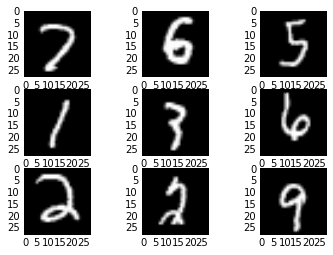

In [25]:
import matplotlib.pyplot as pyplot

for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(XT[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
pyplot.show()

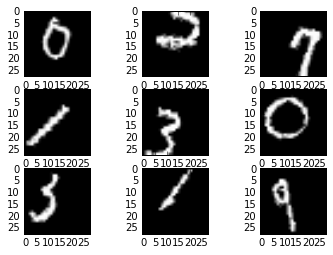

In [15]:
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(generated_images[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()

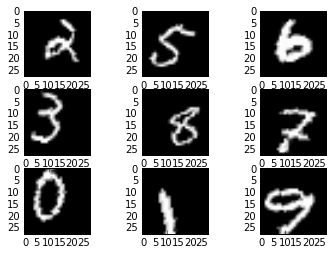

In [16]:
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(generated_images_v[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()

In [14]:
X = np.concatenate((XT, generated_images))
print (X.shape)
n = XT.shape[0]
y = np.zeros([2*n,2])
print (y.shape)
y[:n,1] = 1
y[n:,0] = 1

(100000, 1, 28, 28)
(100000, 2)


In [15]:
y

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [16]:
val_X=np.concatenate((XV, generated_images_v))
print (val_X.shape)
n = XV.shape[0]
val_y = np.zeros([2*n,2])
print (val_y.shape)
val_y[:n,1] = 1
val_y[n:,0] = 1
print (val_y)

(20000, 1, 28, 28)
(20000, 2)
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [17]:
shp = XT.shape[1:]
dropout_rate = 0.25
opt = Adam(lr=1e-4)
#dopt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
print (shp)

(1, 28, 28)


# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
#encoder = Dense(40,activation='sigmoid')(H)
encoder = Dense(40)(H)
d_V = Dense(2,activation='softmax')(encoder)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

encoder = Model(d_input,encoder)
encoder.compile(loss='categorical_crossentropy', optimizer=dopt)
encoder.summary()

In [18]:
# Build Discriminative model ...
# this is our input placeholder
input_img = Input(shape=(1,28,28))

x = convolutional.Convolution2D(16, 5, 5, activation='relu', border_mode='same')(input_img)
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x)
#x = Dropout(dropout_rate)(x)

x = convolutional.Convolution2D(32, 5, 5, activation='relu', border_mode='same')(x) 
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x) 
x = Dropout(dropout_rate)(x)

x = convolutional.Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x) 
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x) 
x = Dropout(dropout_rate)(x)

##x = convolutional.Convolution2D(10, 2, 2, activation='relu', border_mode='same')(x)
#encoded = convolutional.MaxPooling2D((2, 2), border_mode='same')(x) 

x = Flatten()(x)
encoder = Dense(40, activation='relu')(x)
d_V = Dense(2,activation='softmax')(encoder)
discriminator = Model(input_img,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt,metrics=['accuracy'])
discriminator.summary()

encoder = Model(input_img,encoder)
encoder.compile(loss='categorical_crossentropy', optimizer=dopt,metrics=['accuracy'])
encoder.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 28, 28)    416         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 14, 14)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 14, 14)    12832       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(64, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(128, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(128)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
#encoder = Dense(40,activation='sigmoid')(H)--not gving accuracy?what is the default?
encoder = Dense(40)(H)
d_V = Dense(2,activation='softmax')(encoder)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

encoder = Model(d_input,encoder)
encoder.compile(loss='categorical_crossentropy', optimizer=dopt)
encoder.summary()

In [19]:
nb_epoch=50
batch_size=128
random_state =557891

In [20]:
kfold_weights_path = os.path.join('weights_kfold_' +  'MNIST-Aug_Discmtv_Conn_Encoder-Ver1.451' +
                                  '_epoch_'+str(nb_epoch)+
                                  '_batch_'+str(batch_size)
                                  +'.h5')
print(kfold_weights_path)

weights_kfold_MNIST-Aug_Discmtv_Conn_Encoder-Ver1.451_epoch_50_batch_128.h5


In [21]:
os.path.isfile(kfold_weights_path)

True

In [22]:
# Some transfer learning
if os.path.isfile(kfold_weights_path):
    print ('Loading already stored weights...')
    discriminator.load_weights(kfold_weights_path)
else:
    print ('Training for the first time...')
    

Loading already stored weights...


In [23]:
callbacks = [
                EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=1),
            ]
history=discriminator.fit(X, y,
            nb_epoch=nb_epoch,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(val_X, val_y),
            callbacks=callbacks
            )

Train on 100000 samples, validate on 20000 samples
Epoch 1/50
100000/100000 [==============================] - 115s - loss: 0.0463 - acc: 0.9858 - val_loss: 0.0326 - val_acc: 0.9890
Epoch 2/50
100000/100000 [==============================] - 114s - loss: 0.0441 - acc: 0.9862 - val_loss: 0.0290 - val_acc: 0.9911
Epoch 3/50
100000/100000 [==============================] - 117s - loss: 0.0419 - acc: 0.9870 - val_loss: 0.0286 - val_acc: 0.9908
Epoch 4/50
100000/100000 [==============================] - 112s - loss: 0.0396 - acc: 0.9877 - val_loss: 0.0276 - val_acc: 0.9907
Epoch 5/50
100000/100000 [==============================] - 115s - loss: 0.0394 - acc: 0.9877 - val_loss: 0.0361 - val_acc: 0.9879
Epoch 6/50
100000/100000 [==============================] - 112s - loss: 0.0386 - acc: 0.9881 - val_loss: 0.0282 - val_acc: 0.9906
Epoch 7/50
100000/100000 [==============================] - 112s - loss: 0.0369 - acc: 0.9886 - val_loss: 0.0352 - val_acc: 0.9885
Epoch 8/50
100000/100000 [======

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


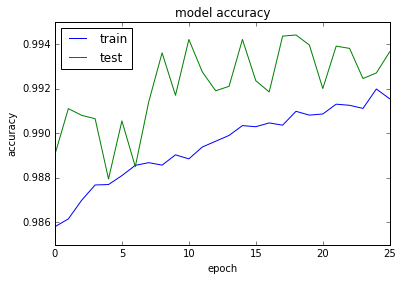

In [26]:
print(history.history.keys())
# summarize history for accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()


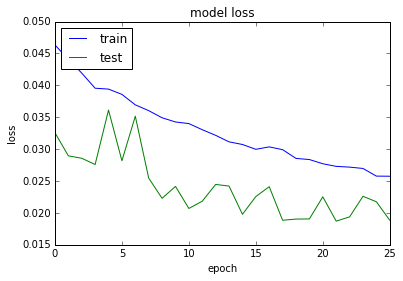

In [27]:
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [28]:
encoded_train_imgs = encoder.predict(train_x_temp)
print (encoded_train_imgs.size)
print (encoded_train_imgs.shape)
print (encoded_train_imgs.nbytes)

2000000
(50000, 40)
16000000


In [29]:
encoded_test_imgs = encoder.predict(test_x_temp)
print (encoded_test_imgs.size)
print (encoded_test_imgs.shape)
print (encoded_test_imgs.nbytes)

400000
(10000, 40)
3200000


In [113]:
encoded_test_imgs

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.21667886,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.0814085 ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.86192989,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         5.70158529,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [30]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf = clf.fit(encoded_train_imgs, y_train)

In [31]:
y_pred = clf.predict(encoded_test_imgs)


In [32]:
y_pred

array([ 7.,  2.,  1., ...,  9.,  8.,  6.])

In [33]:
y_test

array([ 7.,  2.,  1., ...,  4.,  5.,  6.])

In [34]:
num=len(encoded_test_imgs)
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")
# With Val only having Real images 5 epochs - 48.17%
# With Val also having generated images +5 epochs - 28.89%
# With Model complexity reduced and 5 epochs - 82.4%
# With Model complexity reduced and 5 epochs - 81.4%
# With1.1 ZCA added and 50 epochs - 64.61%
# With1.1 ZCA removed and 50 epochs - 82.86%

tested  10000 digits
correct:  7629 wrong:  2371 error rate:  23.71 %
got correctly  76.29 %


Clustering...

In [43]:
from sklearn import linear_model
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA

In [43]:
# apply pca to reduce to 2 dimensions
reduced_train_data = PCA(n_components=2).fit_transform(encoded_train_imgs)
reduced_test_data = PCA(n_components=2).fit_transform(encoded_test_imgs)


In [44]:
# dont appy and further DR
reduced_train_data = encoded_train_imgs
reduced_test_data = encoded_test_imgs


In [45]:
print (reduced_train_data.shape)
print (reduced_test_data.shape)

(50000, 40)
(10000, 40)


In [46]:
print(y_train.shape)
y_train_pd=y_train.reshape(50000,1)
print(y_train_pd.shape)
print (y_test.shape)
y_test_pd=y_test.reshape(10000,1)

print (y_test_pd.shape)

(50000,)
(50000, 1)
(10000,)
(10000, 1)


In [47]:
train_df = pd.DataFrame(reduced_train_data)

In [48]:
train_df['Label'] = pd.DataFrame(y_train_pd)

In [49]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,Label
0,44.172901,80.101318,57.157349,48.919014,-4.873997,83.437462,6.429060,-133.290268,113.991096,-30.597767,...,-70.215256,-51.206177,1.344082,10.625076,-42.722263,165.196030,22.547836,110.217178,5.063454,5.0
1,42.489975,87.068733,58.592953,57.192947,1.604520,87.625175,10.705535,-142.677841,119.358711,-28.492935,...,-79.125916,-50.867664,0.994127,9.511981,-44.891640,177.835846,18.944477,119.954178,-2.401167,0.0
2,23.452095,45.535316,32.143772,31.401031,0.590254,47.327065,8.753423,-80.654160,62.811562,-11.228618,...,-45.127880,-27.306797,2.817532,8.247489,-23.872173,96.553146,11.744184,68.200241,-4.610242,4.0
3,32.281712,63.571724,44.427872,35.422047,0.784749,68.588379,0.810882,-105.797661,95.810707,-26.971449,...,-50.163067,-39.763065,-0.445694,7.675542,-42.680439,128.394089,19.388569,85.491943,11.926619,1.0
4,45.041615,86.868088,55.051579,50.896107,-1.170558,85.019684,5.605784,-141.929443,121.501221,-29.884911,...,-68.822006,-58.042744,-0.704793,15.569777,-49.800476,173.143372,27.273251,115.294472,7.662761,9.0


In [50]:
#test_df = pd.DataFrame(reduced_test_data,columns=list('AB'))
test_df = pd.DataFrame(reduced_test_data)
test_df['Label'] = pd.DataFrame(y_test_pd)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,Label
0,29.102270,55.892616,36.242229,34.103996,-1.714672,56.537525,4.262784,-91.840912,77.717575,-19.084759,...,-47.496040,-36.668053,-0.259912,8.181935,-30.308220,112.767433,16.382227,75.244522,2.493395,7.0
1,47.545105,70.862389,55.005138,42.957127,-9.309855,76.660896,11.978909,-121.646790,100.862061,-27.461523,...,-65.827957,-46.576721,8.515875,13.076570,-36.004536,155.900101,23.448761,104.419029,2.719755,2.0
2,20.818821,38.016750,25.783333,20.835579,-1.370073,39.983494,0.959094,-62.872303,56.363949,-15.484451,...,-28.587330,-25.013227,-0.269255,6.385770,-24.634493,76.326019,13.197577,50.952347,7.802516,1.0
3,63.258415,118.308273,80.145393,72.303345,-3.287868,118.326897,11.329537,-197.113586,164.264786,-39.898129,...,-102.256905,-76.898544,3.204404,19.162313,-62.108604,241.935211,33.350620,162.449799,2.595430,0.0
4,31.619122,59.747513,39.610233,37.000698,-1.720964,59.194931,6.956316,-101.430664,82.045586,-17.807995,...,-52.648151,-39.078835,2.448805,11.874126,-31.605885,122.517487,17.915546,83.773354,-0.694030,4.0


In [51]:
# Create kmeans
clstr = KMeans(n_clusters=10)
clstr.fit(reduced_train_data) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Create feature agglomeration
from sklearn.cluster import FeatureAgglomeration
clstr = FeatureAgglomeration(n_clusters=10)
clstr.fit_transform(reduced_train_data) 
clstr.fit_transform(reduced_test_data) 

from sklearn.cluster import Birch

clstr=Birch(branching_factor=50, n_clusters=10, threshold=0.5,compute_labels=True)
clstr.fit(reduced_train_data) 

In [52]:
clstr.cluster_centers_.shape

(10, 40)

clstr.cluster_centers_

In [53]:
clstr.labels_.shape

(50000,)

In [54]:
clstr_predicted = clstr.predict(reduced_test_data)
#clstr_predicted = clstr.fit_transform(reduced_test_data) 

In [55]:
cluster= clstr_predicted
print (cluster.shape)
cluster=cluster.reshape(10000,1)
print (cluster.shape)

(10000,)
(10000, 1)


In [56]:
np.unique(cluster)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [57]:
np.unique(test_df.Label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [58]:
test_df['Cluster'] = pd.DataFrame(cluster)
test_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,Label,Cluster
0,29.102270,55.892616,36.242229,34.103996,-1.714672,56.537525,4.262784,-91.840912,77.717575,-19.084759,...,-36.668053,-0.259912,8.181935,-30.308220,112.767433,16.382227,75.244522,2.493395,7.0,1
1,47.545105,70.862389,55.005138,42.957127,-9.309855,76.660896,11.978909,-121.646790,100.862061,-27.461523,...,-46.576721,8.515875,13.076570,-36.004536,155.900101,23.448761,104.419029,2.719755,2.0,8
2,20.818821,38.016750,25.783333,20.835579,-1.370073,39.983494,0.959094,-62.872303,56.363949,-15.484451,...,-25.013227,-0.269255,6.385770,-24.634493,76.326019,13.197577,50.952347,7.802516,1.0,9
3,63.258415,118.308273,80.145393,72.303345,-3.287868,118.326897,11.329537,-197.113586,164.264786,-39.898129,...,-76.898544,3.204404,19.162313,-62.108604,241.935211,33.350620,162.449799,2.595430,0.0,2
4,31.619122,59.747513,39.610233,37.000698,-1.720964,59.194931,6.956316,-101.430664,82.045586,-17.807995,...,-39.078835,2.448805,11.874126,-31.605885,122.517487,17.915546,83.773354,-0.694030,4.0,3
5,30.088165,57.283504,37.310844,32.185070,-1.030125,59.001419,1.922771,-93.616196,83.786240,-22.313599,...,-37.274612,-1.063989,9.027158,-36.783558,114.154022,18.961212,75.941521,10.716215,1.0,1
6,37.384960,69.695381,45.197643,42.374573,-2.417540,68.784065,6.248705,-115.349236,95.753174,-23.126074,...,-46.328636,0.591296,13.229446,-36.822411,141.081024,20.939838,94.729515,1.330177,4.0,8
7,40.793713,76.735909,47.346928,45.862076,-1.508611,73.601028,6.748085,-125.912025,104.990097,-24.431799,...,-52.235756,0.482468,14.144353,-41.082085,154.221970,23.901434,102.363579,3.847312,9.0,8
8,45.711540,88.400032,62.349369,55.829449,-1.669926,89.849907,11.324306,-149.886429,123.183350,-28.677086,...,-54.110405,4.778359,14.461140,-47.538200,183.399765,23.832640,125.200539,-0.911029,5.0,7
9,56.751514,113.688248,72.661926,67.725616,0.523662,113.769455,6.176911,-187.108505,159.993729,-39.402233,...,-73.504990,-1.440103,18.080669,-65.219780,226.535095,33.153137,151.605194,8.051671,9.0,4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faec8a95fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faebfec4240>]], dtype=object)

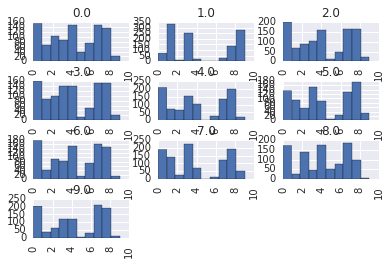

In [59]:
test_df['Cluster'].hist(by=test_df['Label'])

In [60]:
test_df.groupby(['Label','Cluster'])['Cluster'].count()

Label  Cluster
0.0    0          154
       1           67
       2          102
       3           88
       4          150
       5           40
       6           73
       7          148
       8          136
       9           22
1.0    0           72
       1          331
       2           10
       3          248
       4           25
       7           28
       8          140
       9          281
2.0    0          200
       1           70
       2           89
       3          101
       4          162
       5           12
       6           46
       7          166
       8          163
       9           23
3.0    0          160
       1           86
                 ... 
7.0    0          188
       1          142
       2           28
       3          221
       4           72
       5            3
       6           12
       7          121
       8          192
       9           49
8.0    0          171
       1           24
       2          140
       3         

In [61]:
test_df.groupby(['Cluster','Label'])['Label'].count()

Cluster  Label
0        0.0      154
         1.0       72
         2.0      200
         3.0      160
         4.0      208
         5.0      135
         6.0      177
         7.0      188
         8.0      171
         9.0      203
1        0.0       67
         1.0      331
         2.0       70
         3.0       86
         4.0       72
         5.0       91
         6.0       41
         7.0      142
         8.0       24
         9.0       41
2        0.0      102
         1.0       10
         2.0       89
         3.0       97
         4.0       64
         5.0       54
         6.0       93
         7.0       28
         8.0      140
         9.0       66
                 ... 
7        0.0      148
         1.0       28
         2.0      166
         3.0      151
         4.0      135
         5.0      131
         6.0      163
         7.0      121
         8.0      185
         9.0      209
8        0.0      136
         1.0      140
         2.0      163
         3.0     

In [155]:
test_df.groupby(['Cluster'])['Label'].count()

Cluster
0    1068
1     966
2     885
3     953
4     880
5    1163
6     829
7     817
8    1008
9    1431
Name: Label, dtype: int64

In [63]:
#Determine Cluster accuracy
from scipy.stats import mode 


In [64]:
f = lambda x: mode(x, axis=None)[0]

test_df.groupby(['Cluster'])['Label'].apply(f)

Cluster
0    [4.0]
1    [1.0]
2    [8.0]
3    [1.0]
4    [8.0]
5    [8.0]
6    [8.0]
7    [9.0]
8    [4.0]
9    [1.0]
Name: Label, dtype: object

In [65]:
#Actual_Label = test_df['Label'].tolist()
#Cluster_Label = test_df['Cluster'].tolist()
Actual_Label = np.array(test_df['Label'])
Cluster_Label = np.array(test_df['Cluster'])

In [66]:
Actual_Label

array([ 7.,  2.,  1., ...,  4.,  5.,  6.])

In [67]:
Cluster_Label

array([1, 8, 9, ..., 4, 7, 2], dtype=int32)

In [68]:
Assigned_labels=np.zeros_like(Cluster_Label)
#Assigned_labels = Assigned_labels.tolist()
#Assigned_labels

In [162]:
Cluster_Label==1

array([False, False, False, ..., False, False, False], dtype=bool)

In [69]:
for i in range(10):
    print(i)
    mask=(Cluster_Label==i)
    #print(mask)
    Assigned_labels[mask]= mode(Actual_Label[mask])[0]
    print(len(Actual_Label[mask]))
    print(mode(Actual_Label[mask])[0])
    print(len(Assigned_labels[mask]))
    #print(labels[i])
print(np.array(Assigned_labels))

0
1668
[ 4.]
1668
1
965
[ 1.]
965
2
743
[ 8.]
743
3
1351
[ 1.]
1351
4
1193
[ 8.]
1193
5
146
[ 8.]
146
6
413
[ 8.]
413
7
1437
[ 9.]
1437
8
1598
[ 4.]
1598
9
486
[ 1.]
486
[1 4 1 ..., 8 9 8]


In [70]:
Assigned_labels=np.array(Assigned_labels)

In [71]:
from sklearn.metrics import accuracy_score
accuracy_score(Assigned_labels,Actual_Label)

0.19189999999999999

In [136]:
Assigned_labels.shape

(10000,)

In [135]:
Actual_Label.shape

AttributeError: 'list' object has no attribute 'shape'

In [130]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,Label,Cluster
0,1.439396,1.533758,1.705850,2.993416,2.606283,3.178577,2.522242,2.848150,1.819115,0.940211,...,0.962655,1.472043,0.0,0.0,2.228551,0.698205,0.0,1.091734,7.0,0
1,3.876988,0.288837,1.514825,2.628214,4.046387,0.837923,2.547393,1.315813,2.081404,6.372713,...,1.920950,3.983616,0.0,0.0,1.879533,7.051126,0.0,1.306167,2.0,3
2,0.000000,0.860552,1.039834,2.888837,1.980653,1.164428,2.667731,1.959471,1.125587,0.797308,...,1.085797,1.518367,0.0,0.0,1.280862,3.333719,0.0,0.862952,1.0,4
3,4.746442,2.616378,1.453264,1.690279,7.269545,2.916892,3.879184,2.672343,2.504143,5.752549,...,2.177196,3.035470,0.0,0.0,2.508161,2.855093,0.0,2.298105,0.0,9
4,0.785093,2.686178,2.199318,1.730256,1.738629,2.907272,0.339924,0.638922,1.014574,2.956997,...,3.805755,1.695995,0.0,0.0,1.575763,1.248279,0.0,0.966686,4.0,7


In [131]:
test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,Label,Cluster
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.0,10000.0,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000
mean,2.320601,2.141341,2.350264,2.568826,3.482336,2.470676,2.946397,2.105223,2.643307,3.081644,...,2.874107,2.402513,0.0,0.0,2.055657,3.396554,0.0,2.167426,4.443400,4.469900
std,1.478106,1.240657,1.315089,1.215278,2.064826,1.102161,1.091409,0.937434,1.391304,1.663919,...,1.427291,1.277320,0.0,0.0,1.027588,1.586462,0.0,1.324409,2.895865,2.887616
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.245947,1.183887,1.402701,1.664216,1.881223,1.622943,2.250474,1.442623,1.540446,1.852023,...,1.893954,1.479638,0.0,0.0,1.321352,2.215043,0.0,1.181993,2.000000,2.000000
50%,2.149874,2.063359,2.144441,2.526801,3.235991,2.395341,3.002272,2.117733,2.511769,2.908856,...,2.893382,2.316023,0.0,0.0,1.961714,3.429307,0.0,1.970621,4.000000,5.000000
75%,3.205377,2.974270,3.104858,3.447505,4.850150,3.228653,3.678726,2.769303,3.653602,4.277022,...,3.848012,3.244988,0.0,0.0,2.695083,4.513322,0.0,3.044030,7.000000,7.000000
max,8.526831,7.031223,8.093109,6.250950,10.171324,6.767524,6.519832,5.283956,6.969714,8.271577,...,7.962352,7.429311,0.0,0.0,6.465517,8.619820,0.0,7.539230,9.000000,9.000000


In [132]:
test_df.groupby('Cluster').count()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,...,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143
1,879,879,879,879,879,879,879,879,879,879,...,879,879,879,879,879,879,879,879,879,879
2,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,...,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144
3,757,757,757,757,757,757,757,757,757,757,...,757,757,757,757,757,757,757,757,757,757
4,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,...,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062
5,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,...,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036
6,887,887,887,887,887,887,887,887,887,887,...,887,887,887,887,887,887,887,887,887,887
7,1010,1010,1010,1010,1010,1010,1010,1010,1010,1010,...,1010,1010,1010,1010,1010,1010,1010,1010,1010,1010
8,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297,...,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297


In [133]:
test_df_sample=test_df[0:10000]
test_df_sample=test_df_sample[test_df_sample.Label < 3]

sb.set_context("notebook", font_scale=1.1)
sb.set_style("ticks")


sb.lmplot('A','B',
           data=test_df_sample, 
           fit_reg=False, 
           hue="Label",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Histogram of IQ')
plt.xlabel('PC#1')
plt.ylabel('PC#2')

KeyError: "['A' 'B'] not in index"

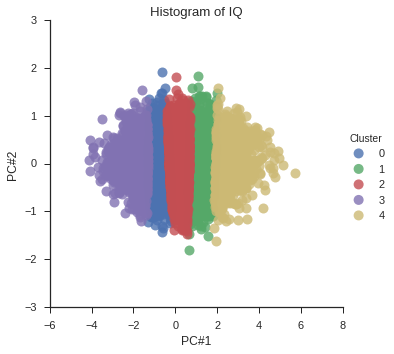

In [63]:
test_df_sample=test_df[0:10000]
test_df_sample=test_df_sample[test_df_sample.Cluster < 10]

sb.set_context("notebook", font_scale=1.1)
sb.set_style("ticks")


sb.lmplot('A','B',
           data=test_df_sample, 
           fit_reg=False, 
           hue="Cluster",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Histogram of IQ')
plt.xlabel('PC#1')
plt.ylabel('PC#2')

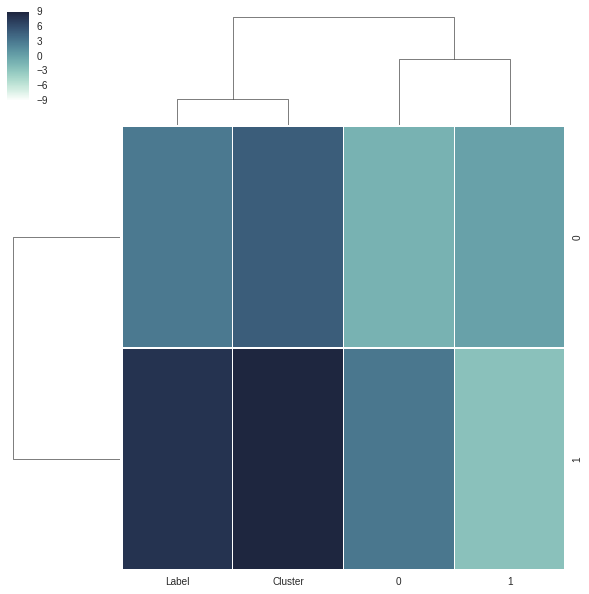

In [120]:
cmap = sb.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
g = sb.clustermap(test_df[0:2], cmap=cmap, linewidths=.5)

In [74]:
reduced_train_data = reduced_train_data[0:501,]

In [75]:
reduced_train_data.shape

(501, 2)

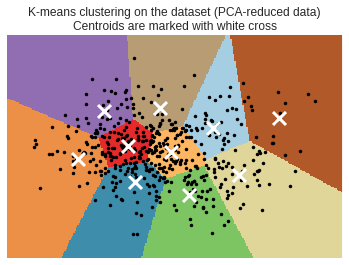

In [76]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .05    # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_train_data[:, 0].min() - 1, reduced_train_data[:, 0].max() + 1
y_min, y_max = reduced_train_data[:, 1].min() - 1, reduced_train_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_train_data[:, 0], reduced_train_data[:, 1], 'k.', markersize=7)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
raw_data['Cluster_Label'] = kmeans.labels_